# PROJETO: HEALTH INSURANCE (*Em andamento*)

## Contexto: 

Uma apólice de seguro é um acordo pelo qual uma empresa se compromete a fornecer uma garantia de compensação por perdas, danos, doenças ou morte especificados em troca do pagamento de um prêmio especificado. Um prêmio é uma quantia em dinheiro que o cliente precisa pagar regularmente a uma companhia de seguros por essa garantia.

Uma companhia de seguros que fornece diferentes tipos de seguros a seus clientes precisa construir de um modelo para prever se os segurados (clientes) que adquiriram seguro de saúde no ano anterior também estariam interessados no seguro de veículo fornecido pela empresa.

Construir um modelo para prever se um cliente estaria interessado em Seguro de Veículo é extremamente útil para a empresa, pois ela pode planejar sua estratégia de comunicação para alcançar esses clientes e otimizar seu modelo de negócios e receita.

## Dados

Os dados para esse projeto são publicos e disponibilizados na plataforma Kaggle, no endereço: https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-predictions

### Descrição dos dados

Nos dados temos informações gerais sobre os clientes que já adquiriram o seguro de saúde oferecido pela seguradora. O dataset original contém as seguintes informações:

<details><summary><strong> Descrição dos dados disponibilizados</strong> </summary>



| Variável            | Descrição                                                                                           |
|---------------------|-----------------------------------------------------------------------------------------------------|
| id                  | ID único do cliente                                                                                 |
| Gender              | Gênero do cliente                                                                                   |
| Age                 | Idade do cliente                                                                                    |
| Driving_License     | 0: Cliente não possui CNH, 1: Cliente já possui CNH                                                 |
| Region_Code         | Código único para a região do cliente                                                               |
| Previously_Insured  | 1: Cliente já possui Seguro de Veículo, 0: Cliente não possui Seguro de Veículo                     |
| Vehicle_Age         | Idade do Veículo                                                                                    |
| Vehicle_Damage      | 1: Cliente teve seu veículo danificado no passado, 0: Cliente não teve seu veículo danificado      |
| Annual_Premium      | O valor que o cliente precisa pagar como prêmio anual                                              |
| Policy_Sales_Channel| Código anonimizado para o canal de abordagem ao cliente                                             |
| Vintage             | Número de dias que o cliente está associado à empresa                                              |
| Response            | 1: Cliente está interessado, 0: Cliente não está interessado                                       |

</details>

## Objetivos

Como cientista de dados foi nos dado a tarefa de desenvolver um modelo de propensão de compra para prever quais clientes que já possuem um plano de saúde da mesma seguradora têm maior probabilidade de adquirir um seguro de carro. O objetivo é fornecer informações ao time de Marketing, permitindo que eles acessem facilmente esses clientes e desenvolvam uma estratégia de vendas eficaz. Além disso, foi solicitado que os resultados sejam disponibilizados em uma tabela no Google Sheets para facilitar o acesso e análise dos dados.

## Métodologia

Este projeto foi feito seguindo o modelo CRISP-DS.



# 0.0 UTILS

## 0.1 Bibliotecas

Bibliotecas utilizadas

In [1]:
import os
import numpy                as np
import pandas               as pd
import pickle
import seaborn              as sns
import inflection
import scikitplot           as skplt
import matplotlib.pyplot    as plt 
import plotly.graph_objects as go

from imblearn.under_sampling    import RandomUnderSampler

from plotly.subplots            import make_subplots

from sklearn                    import preprocessing as pp
from sklearn.metrics            import accuracy_score, confusion_matrix, make_scorer
from sklearn.ensemble           import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.linear_model       import LogisticRegression
from sklearn.model_selection    import cross_val_score, train_test_split

from skopt.space                import Integer, Real, Categorical
from skopt.utils                import use_named_args
from skopt                      import gp_minimize

from xgboost                    import XGBClassifier

## 0.2 Funções

Funções auxiliares

In [2]:
def desc_num(num_attributes):
    #Medidas de tendencia central - mmedia e mediana
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    #Medidas de dispersão - desvio padrão, min, max, range, skewness, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()

    m.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

    display(m)

In [3]:

def precision_at_k_score(y_true, y_pred, k):
    data = pd.DataFrame({'response': y_true, 'score': y_pred})
    data = data.sort_values('score', ascending=False).reset_index(drop=True)
    data['ranking'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k'], data.loc[np.floor(y_true.shape[0]*25/100), 'precision_at_k'], data.loc[np.floor(y_true.shape[0]*50/100), 'precision_at_k'], data.loc[np.floor(y_true.shape[0]*75/100), 'precision_at_k'], data.loc[np.floor(y_true.shape[0]-1), 'precision_at_k']

def recall_at_k_score(y_true, y_pred, k):
    data = pd.DataFrame({'response': y_true, 'score': y_pred})
    data = data.sort_values('score', ascending=False).reset_index(drop=True)
    data['ranking'] = data.index + 1
    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()
    
    return data.loc[k, 'recall_at_k'], data.loc[np.floor(y_true.shape[0]*25/100), 'recall_at_k'], data.loc[np.floor(y_true.shape[0]*50/100), 'recall_at_k'], data.loc[np.floor(y_true.shape[0]*75/100), 'recall_at_k'], data.loc[np.floor(y_true.shape[0]-1), 'recall_at_k']


In [4]:
def ml_error(model_name, y_true, yhat, k):
    pak, pa25, pa50, pa75, pa100 = precision_at_k_score(y_true,yhat,k)
    rak, ra25, ra50, ra75, ra100 = recall_at_k_score(y_true, yhat, k)
    
    return pd.DataFrame({'Model Name': model_name,
                         'Precision at k': pak,
                         'Recall at k': rak,
                         'Precision at 25%': pa25,
                         'Recall at 25%': ra25,
                         'Precision at 50%': pa50,
                         'Recall at 50%': ra50,
                         'Precision at 75%': pa75,
                         'Recall at 75%': ra75,
                         'Precision at 100%': pa100,
                         'Recall at 100%': ra100}, index=[0])

In [5]:
def cross_validation(X, y, k, kfold, model_name, model, verbose=False):
    top_k_precision=[]
    top_k_recall=[]
    top_25_precision=[]
    top_25_recall=[]
    top_50_precision=[]
    top_50_recall=[]
    top_75_precision=[]
    top_75_recall=[]
    top_100_precision=[]
    top_100_recall=[]

    
    
    for n in reversed(range(1,kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(n))

        xtraining, xvalidation, ytraining, yvalidation = train_test_split( X, y, test_size=0.20 )
        m = model.fit(xtraining, ytraining)

        yhat = m.predict_proba(xvalidation)[:,1]

        m_result = ml_error(model_name, yvalidation, yhat, k)
        top_k_precision.append(m_result['Precision at k'])
        top_k_recall.append(m_result['Recall at k'])
        top_25_precision.append(m_result['Precision at 25%'])
        top_25_recall.append(m_result['Recall at 25%'])
        top_50_precision.append(m_result['Precision at 50%'])
        top_50_recall.append(m_result['Recall at 50%'])
        top_75_precision.append(m_result['Precision at 75%'])
        top_75_recall.append(m_result['Recall at 75%'])
        top_100_precision.append(m_result['Precision at 100%'])
        top_100_recall.append(m_result['Recall at 100%'])
        

        top_k_precision_mean = np.mean(top_k_precision)
        top_k_recall_mean    = np.mean(top_k_recall)

    return  top_k_precision_mean, top_k_recall_mean, pd.DataFrame({'Model Name': model_name,
                                                                   'Precision at k':  np.round(np.mean(top_k_precision),4).astype(str) + '+/-' + np.round(np.std(top_k_precision),4).astype(str),
                                                                   'Recall at k': np.round(np.mean(top_k_recall),4).astype(str) + '+/-' + np.round(np.std(top_k_recall),4).astype(str),
                                                                   'Precision at 25%':  np.round(np.mean(top_25_precision),4).astype(str) + '+/-' + np.round(np.std(top_25_precision),4).astype(str),
                                                                   'Recall at 25%': np.round(np.mean(top_25_recall),4).astype(str) + '+/-' + np.round(np.std(top_25_recall),4).astype(str),
                                                                   'Precision at 50%':  np.round(np.mean(top_50_precision),4).astype(str) + '+/-' + np.round(np.std(top_50_precision),4).astype(str),
                                                                   'Recall at 50%': np.round(np.mean(top_50_recall),4).astype(str) + '+/-' + np.round(np.std(top_50_recall),4).astype(str),
                                                                   'Precision at 75%':  np.round(np.mean(top_75_precision),4).astype(str) + '+/-' + np.round(np.std(top_75_precision),4).astype(str),
                                                                   'Recall at 75%': np.round(np.mean(top_75_recall),4).astype(str) + '+/-' + np.round(np.std(top_75_recall),4).astype(str),
                                                                   'Precision at 100%':  np.round(np.mean(top_100_precision),4).astype(str) + '+/-' + np.round(np.std(top_100_precision),4).astype(str),
                                                                   'Recall at 100%': np.round(np.mean(top_100_recall),4).astype(str) + '+/-' + np.round(np.std(top_100_recall),4).astype(str)}, index=[0])

In [6]:
def gain_curve(x_val,y_val,model):

    yhat = model.predict_proba(x_val)

    results = pd.DataFrame()
    results['prediction'] = yhat[:,1].tolist()
    results['real'] = y_val.tolist()

    # ordering by prediction
    results = results.sort_values( 'prediction', ascending=False )

    # Percentage of intereset ( Propensity Score )
    results['real_cum'] = results['real'].cumsum() 
    results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

    # Percentage of Base ( Clients )
    results['base'] = range( 1, len( results ) + 1  )
    results['base_cum_perc'] = 100*results['base']/len( results )

    # Basline model
    results['baseline'] = results['base_cum_perc']

    fig = go.Figure()
    
    fig.add_trace(go.Scatter(name='Classe 1', x=results['base_cum_perc'], y=results['real_cum_perc'], mode='lines'))
    
    fig.add_trace(go.Scatter(name='base line', x=results['base_cum_perc'], y=results['baseline'], mode='lines'))
    
    fig.update_layout(autosize=False,
                      xaxis_title='Percentage of sample',
                      yaxis_title='Gain',
                      width=500,
                      height=500,
                      margin = dict(l=0, r=0, b=0, t=0),
                      legend=dict(orientation = 'h', yanchor = 'top', y=1.11))
    fig.show('png')


In [7]:
def lift_curve(x_val,y_val,model):

    yhat = model.predict_proba(x_val)

    results = pd.DataFrame()
    results['prediction'] = yhat[:,1].tolist()
    results['real'] = y_val.tolist()

    # ordering by prediction
    results = results.sort_values( 'prediction', ascending=False )

    # Percentage of intereset ( Propensity Score )
    results['real_cum'] = results['real'].cumsum() 
    results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

    # Percentage of Base ( Clients )
    results['base'] = range( 1, len( results ) + 1  )
    results['base_cum_perc'] = 100*results['base']/len( results )

    # Basline model
    results['baseline'] = results['base_cum_perc']

    # Lift Calculation
    results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

    fig = go.Figure()
    
    fig.add_trace(go.Scatter(name='Classe 1', x=results['base_cum_perc'], y=results['lift'], mode='lines'))

    
    fig.update_layout(autosize=False,
                      xaxis_title='base_cum_perc',
                      yaxis_title='lift',
                      width=500,
                      height=500,
                      margin = dict(l=0, r=0, b=0, t=0),
                      legend=dict(orientation = 'h', yanchor = 'top', y=1.11))
    
    fig.update_xaxes(range=[5, 100])
    
    fig.show('png')

In [8]:
def roi_curve(x_val,y_val,model):
    
    yhat = model.predict_proba(x_val)
    
    results = pd.DataFrame()
    results['prediction'] = yhat[:,1].tolist()
    results['real'] = y_val.tolist()
    
    results['bucket'] = results['prediction'].apply( lambda x:  0.9 if x >= 0.90 else 
                                                                0.8 if ( x >= 0.80) & ( x < 0.90 ) else 
                                                                0.7 if ( x >= 0.70) & ( x < 0.80 ) else 
                                                                0.6 if ( x >= 0.60) & ( x < 0.70 ) else 
                                                                0.5 if ( x >= 0.50) & ( x < 0.60 ) else 
                                                                0.4 if ( x >= 0.40) & ( x < 0.50 ) else 
                                                                0.3 if ( x >= 0.30) & ( x < 0.40 ) else 
                                                                0.2 if ( x >= 0.20) & ( x < 0.30 ) else 
                                                                0.1 if ( x >= 0.10) & ( x < 0.20 ) else 0.01 )

    #  Aggregate clients among buckets
    df = results[['prediction','bucket']].groupby( 'bucket' ).agg( {'min', 'count'} ).reset_index()
    df.columns = df.columns.droplevel()
    df.columns = ['index', 'propensity_score', 'clients']

    # Compute revenue and cost
    df['gross_revenue'] = 40 * df['clients'] * df['propensity_score'] 
    df['cost'] = 4 * df['clients']

    df['base'] = df['clients'].sort_values( ascending=True ).cumsum() / df['clients'].sum()

    # revenue
    df['revenue'] = df['gross_revenue'] - df['cost']
    df = df.sort_values( 'index', ascending=False )
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(name='ROI Curve', x=df['base'], y=df['revenue'], mode='lines'))
    
    fig.update_layout(autosize=False,
                      xaxis_title='base',
                      yaxis_title='revenue',
                      width=500,
                      height=500,
                      margin = dict(l=0, r=0, b=0, t=0),
                      legend=dict(orientation = 'h', yanchor = 'top', y=1.11))
    fig.show('png')

## 0.3 Definição de diretórios e carregamento dos dados

In [9]:
BASE_DIR = os.path.dirname(os.path.abspath(''))
DATA_DIR = os.path.join(BASE_DIR,'data')
IMAG_DIR = os.path.join(BASE_DIR,'images')
MODE_DIR = os.path.join(BASE_DIR,'models')

df_raw = pd.read_csv(os.path.join(DATA_DIR,'train.csv'))

# 1.0 DESCRIÇÃO DOS DADOS

## 1.1 Renomeando colunas

Reescrevendo as colunas do dataframe no modo snake_case

In [10]:
df1 = df_raw
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, df1.columns.tolist()))
df1.columns = cols_new

## 1.2 Tipos e dimensão dos dados

Tomando conhecimento das dimensões e os tipo de valores contidos em cada coluna

In [11]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))
df1.dtypes

Number of Rows: 381109
Number of Columns: 12


id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

A coluna vehicle_damage teve os valores 'Yes' e 'No' substituídos por 1 e 0, respectivamente;
A coluna vehicle_age teve seus valores alterados para evitar o uso dos simbolos "<" e ">".

In [12]:
df1['vehicle_damage'] = [1 if i=='Yes' else 0 for i in df1['vehicle_damage']]
df1['vehicle_age'] = ['below_1_year' if i=='< 1 Year' else 'between_1_2_year' if i=='1-2 Year' else 'over_2_year' for i in df1['vehicle_age']]

## 1.3 Verificação de valores nulos

Verificação da quantidade de valores nulos em cada coluna. Não há nenhum, portanto não será necessário o preenchimento de NaN's.

In [13]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4 Estatistica descritiva

Visão estatística das variáveis numéricas presentes no dataframe.

In [14]:
num_attributes = df1[['age', 'annual_premium', 'vintage']]
cat_attributes = df1[['gender', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 'vehicle_damage', 'policy_sales_channel']]

In [15]:
desc_num(num_attributes)

attributes     min       max     range          mean   median  \
0             age    20.0      85.0      65.0     38.822584     36.0   
1  annual_premium  2630.0  540165.0  537535.0  30564.389581  31669.0   
2         vintage    10.0     299.0     289.0    154.347397    154.0   

            std      skew   kurtosis  
0     15.511591  0.672539  -0.565655  
1  17213.132474  1.766087  34.004569  
2     83.671194  0.003030  -1.200688

In [16]:
display(cat_attributes.apply(lambda x: x.unique().shape[0]))

display(cat_attributes.apply(lambda x: x.unique()))

gender                    2
driving_license           2
region_code              53
previously_insured        2
vehicle_age               3
vehicle_damage            2
policy_sales_channel    155
dtype: int64

gender                                                     [Male, Female]
driving_license                                                    [1, 0]
region_code             [28.0, 3.0, 11.0, 41.0, 33.0, 6.0, 35.0, 50.0,...
previously_insured                                                 [0, 1]
vehicle_age                 [over_2_year, between_1_2_year, below_1_year]
vehicle_damage                                                     [1, 0]
policy_sales_channel    [26.0, 152.0, 160.0, 124.0, 14.0, 13.0, 30.0, ...
dtype: object

# 2.0 FEATURE ENGINEERING


<img src='../images/mapa_mental.png' width='900'>

## 2.1 Hipoteses levantadas

- Pessoas mais velhas se interessam mais em adquirir o seguro;
- Pessoas com familia (Esposa/Marido e filhos) se interessam mais em adquirir o seguro;
- Pessoas com profissões que exigem locomoção de carro se interessam mais pelo seguro;
- Pessoas com maior salario se interessam mais pelo seguro;
- Pessoas que já possuem seguro não se interessam em outro seguro;
- Pessoas com Habilitação tendem a adquirir o seguro;
- Homens deveriam se interessar mais pelo seguro do que mulheres.


---

- Em locais com alta taxa de criminalidade há maior interesse pelo seguro;
- Em locais onde existem estradas em má condições há um interesse maior pelo seguro.

---

- Pessoas com carros mais antigos dispensam mais o seguro;
- Pessoas com carros mais caros estão mais propensos a adquirir o seguro;
- Pessoas com carros que já foram danificados alguma vez tendem a adquirir o seguro.

---

- Pessoas que recém adquiriram o plano de saúde podem não se interessar de imediato em um seguro de carro;
- Pessoas que são contatadas por telefone tendem adquirir o seguro mais que outros meios;
- Pessoas no fim do seguro de saúde, quando oferecido renovação, tendem a adquirir o junto o seguro de carro.

## 2.2 Hipóteses que podem ser verificadas com os dados disponiveis


- **H1** Pessoas mais velhas se interessam mais em adquirir o seguro;
- **H2** Pessoas que já possuem seguro não se interessam em adquirir outro;
- **H3** Pessoas com Habilitação tendem a adquirir o seguro;
- **H4** Homens deveriam se interessar mais pelo seguro do que mulheres.

---

- **H5** Pessoas com carros mais antigos dispensam mais o seguro;
- **H6** Pessoas com carros que já foram danificados alguma vez tendem a adquirir o seguro.

---

- **H7** Pessoas que recém adquiriram o plano de saúde podem não se interessar de imediato em um seguro de carro;
- **H8** Pessoas no fim do seguro de saúde, quando oferecido renovação, tendem a adquirir o junto o seguro de carro *(em partes)*;
- **H9** Pessoas que são contatadas por telefone tendem adquirir o seguro mais que outros meios *(em partes)*


Criação de uma nova feature 'total_expense' que representa o valor total gasto pelo cliente. O calculo feito considerando um intervalo de tempo mensal, o prêmio total foi dividido por 12 e o tempo em meses do cliente como mês que ele se encontra no serviço, portanto um cliente que acabou de obter o plano de saúde estaria no seu primeiro mês na base, outro que está a 31 dias (tomando como base um mês de 30 dias, já que não temos referência temporal) estaria no segundo mês e assim sucessivamente.

In [17]:
df2 = df1.copy()
df2['total_expense'] = (df2['annual_premium']/12)*((np.floor(df2['vintage']/30))+1)

Para responder H7 e H8 vamos precisar definir o intervalo de tempo que caracteriza um cliente novo e um antigo. Para isso vamos criar uma nova variável categórica que separa o tempo dos clientes na base em quadrimestre: tempo < quatro meses => 1; quatro meses < tempo < oito meses => 2; e tempo > oito meses => 3

In [18]:
df2['quadrimestre'] = np.floor(df2['vintage']/30)+1
df2['quadrimestre'] = df2['quadrimestre'].apply(lambda x: 1 if x<4 else 2 if (x>=4 and x<8) else 3)

# 3.0 FILTRAGEM DE VARIAVEIS

Não há variáveis com restrição, todas serão utilizadas

# 4.0 EDA

Etapa da análise exploratória dos dados

In [19]:
df4 = df2.copy()
df4.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response', 'total_expense',
       'quadrimestre'],
      dtype='object')

## 4.1 Verificação do balanço dos dados

Estamos trabalhando com dados categóricos, portanto precisamos verificar se temos quantidades significativas  de cada categoria. Nesse caso vemos que temos muito menos dados de pessoas que adquiririam o seguro, portanto, posteriormente, será necessário balancear o dataset antes de treinar o modelo para evitar uma falsa acurácia do modelo.

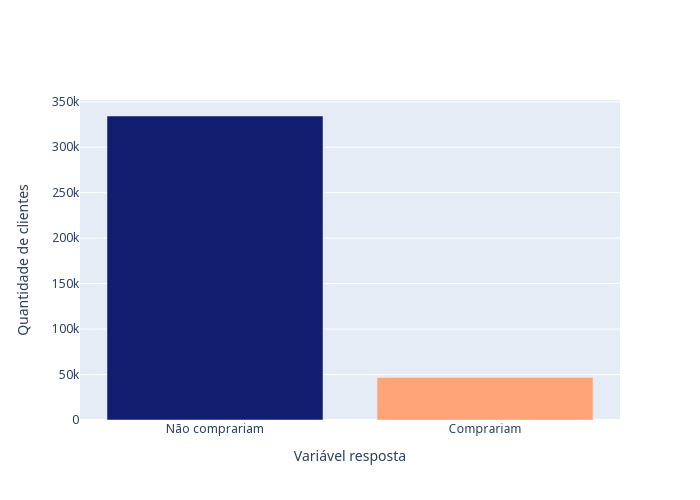

In [20]:
aux = df4.loc[:,['response']].groupby('response').size().reset_index(name='qnt')

fig = go.Figure(go.Bar(x=aux['response'], y=aux['qnt'], marker_color=['#111D6F', '#FFA378']))

fig.update_layout(xaxis_title='Variável resposta', yaxis_title='Quantidade de clientes',
                  xaxis = dict(tickmode = 'array', tickvals = [0, 1], ticktext = ['Não comprariam', 'Comprariam']),
                  showlegend = False, autosize=False)
fig.show('png')


## 4.2 Análise univariada

### 4.2.1 Distribuição da idade

Observando a curva de distribuição da idade vemos que ela se assemelha mais a uma distribuição de Poisson do que uma normal. A base de clientes assegurados com plano de saúde é mais concentrada nas idades de 23~24 anos, apresentando também um acumulo consideravel entre 43~45 anos.

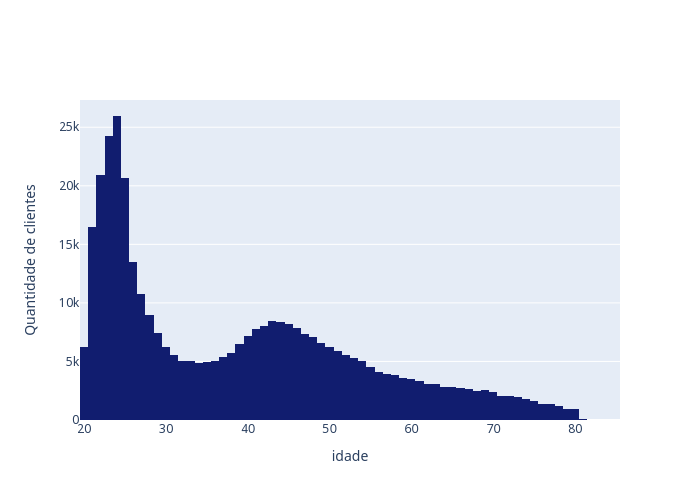

In [21]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df4['age'], marker_color='#111D6F'))

# Overlay both histograms
fig.update_layout(barmode='overlay',autosize=False, xaxis_title='idade', yaxis_title='Quantidade de clientes')
# Reduce opacity to see both histograms
fig.show('png')

### 4.2.2 Distribuição do valor do prêmio pago

Vemos que existe uma alta concentração de valores entre 2 e 3 mil dólares, em seguida, para valores maiores a distribuição aparenta ser uma normal com skewness positiva e uma alta Kurtosis, como também pode ser visto na seção 1.5.

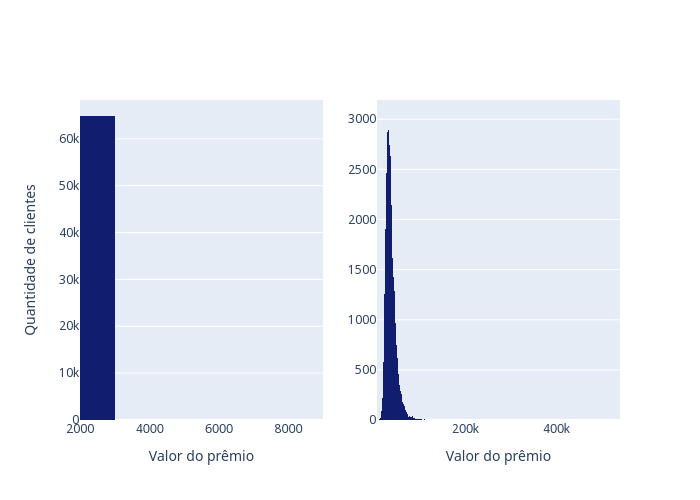

In [22]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Histogram(x=df4[df4['annual_premium']<=9000]['annual_premium'], marker_color='#111D6F'), row=1, col=1)
fig.add_trace(go.Histogram(x=df4[df4['annual_premium']>=4000]['annual_premium'], marker_color='#111D6F'), row=1, col=2)

# Overlay both histograms
fig.update_layout(barmode='overlay', yaxis_title='Quantidade de clientes',showlegend = False)
fig.update_xaxes(title_text="Valor do prêmio", row=1, col=1)
fig.update_xaxes(title_text="Valor do prêmio", row=1, col=2)

# Reduce opacity to see both histograms
fig.show('png')


### 4.2.3 Distribuição da feature Vintage

Aqui temos a distribuição do tempo em que os clientes adquiriram o plano de saúde (em dias). Vemos que os dados estão balanceados já que temos quantidade semelhante de clientes para cada valor de tempo. 

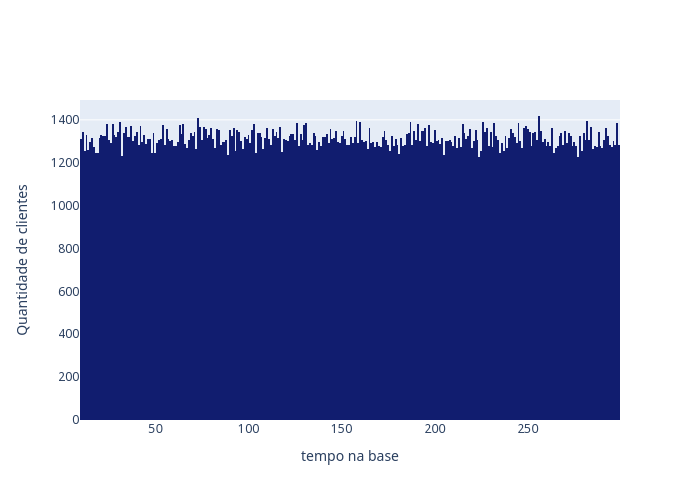

In [23]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df4['vintage'], marker_color='#111D6F'))

# Overlay both histograms
fig.update_layout(barmode='overlay',autosize=False, xaxis_title='tempo na base', yaxis_title='Quantidade de clientes')
# Reduce opacity to see both histograms
fig.show('png')

## 4.3 Análise bivariada

### **H1** Pessoas mais velhas deveriam se interessar mais em adquirir o seguro

**Verdadeiro** De fato, quando analisamos apenas as pessoas interessadas vemos que o maior número de pessoas se concentra em torno dos 40 e 50 anos. Em contrapartida, analisando o caso de desinteresse, vemos uma grande quantidade de jovens desinteressados no seguro. Isso pode ocorrer não só exclusivamente por conta da idade, mas por uma série se fatores que os dados disponíveis não nos permite explorar como o salário, se possuem filhos etc.

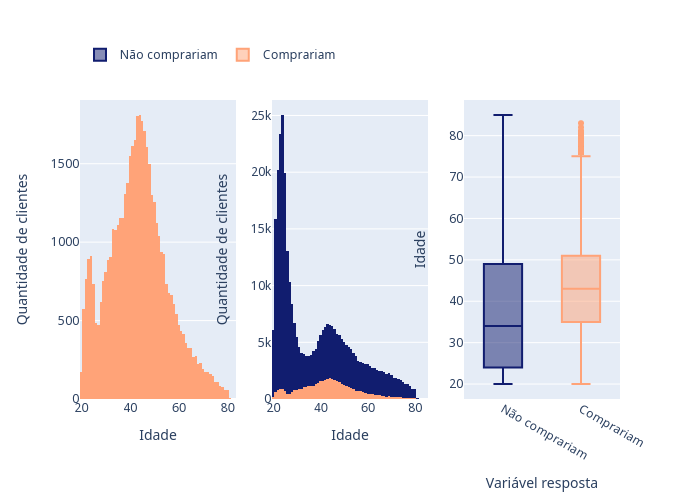

In [24]:
fig = make_subplots(rows=1, cols=3)

# Distribuição da idade apenas dos que comprariam
fig.add_trace(go.Histogram(name='Comprariam', x=df4.loc[df4['response']==1, 'age'], marker_color='#FFA378',showlegend = False), row=1, col=1)

# Distribuição da idade para os dois casos
fig.add_trace(go.Histogram(name='Não comprariam', x=df4.loc[df4['response']==0, 'age'], marker_color='#111D6F',showlegend = False), row=1, col=2)
fig.add_trace(go.Histogram(name='Comprariam', x=df4.loc[df4['response']==1, 'age'], marker_color='#FFA378',showlegend = False), row=1, col=2)

# Boxplot
fig.add_trace(go.Box(name='Não comprariam', y=df4[df4['response']==0]['age'], marker_color ='#111D6F'), row=1, col=3)
fig.add_trace(go.Box(name='Comprariam', y=df4[df4['response']==1]['age'], marker_color ='#FFA378'), row=1, col=3)

# Ajustes de legenda e nome dos eixos
fig.update_xaxes(title_text="Idade", row=1, col=1)
fig.update_yaxes(title_text="Quantidade de clientes", row=1, col=1)

fig.update_xaxes(title_text="Idade", row=1, col=2)
fig.update_yaxes(title_text="Quantidade de clientes", row=1, col=2)

fig.update_xaxes(title_text="Variável resposta", row=1, col=3)
fig.update_yaxes(title_text="Idade", row=1, col=3)

fig.update_layout(barmode='overlay', legend=dict(orientation = 'h', yanchor = 'top', y=1.2))

fig.show('png')

### **H2** Pessoas que já possuem seguro não se interessam em adquirir outro

**Verdadeiro** De fato, pessoas que já possuem seguro não se interessam em adquirir outro (linha 1, coluna 0, 99%), já das que não possuem seguro de carro apenas 22% têm interesse em adquirir um. 

Aqui podemos notar ainda outro ponto que se deve tomar cuidado, o fato de 99% das pessoas que já possui seguro não se interessarem em um novo pode ser um vazamento de dados, podendo causar um falso viés ao treinar o modelo. Um dos motivos disso é o baixo número de pessoas interessadas no seguro no dataset, mais um motivo para realizar o balanceamento dos dados. 

In [25]:
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

response                   0         1
previously_insured                    
0                   0.774546  0.225454
1                   0.999095  0.000905

### **H3** Pessoas com Habilitação tendem a adquirir o seguro

**FALSO** A quantidade de pessoas que possuem licença e não tem interesse em adquirir o seguro é muito maior do que a parcela que tem interesse. Novamente, isso pode ser uma falsa conclusão visto que os dados estão desbalanceados.

In [26]:
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
aux

response  driving_license
0         0           333628
1         1            46669

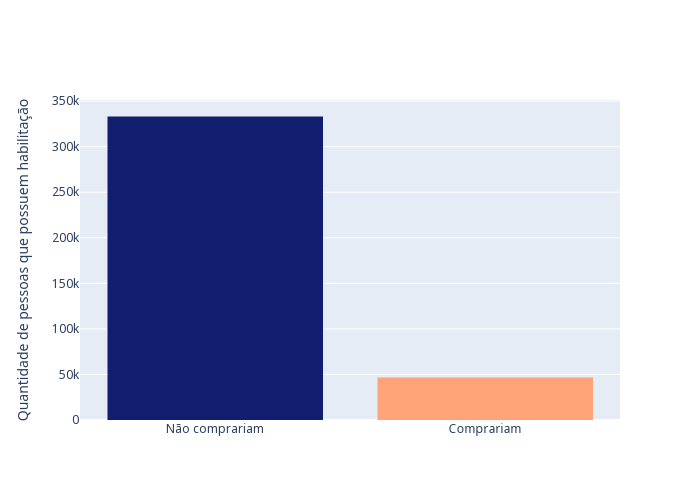

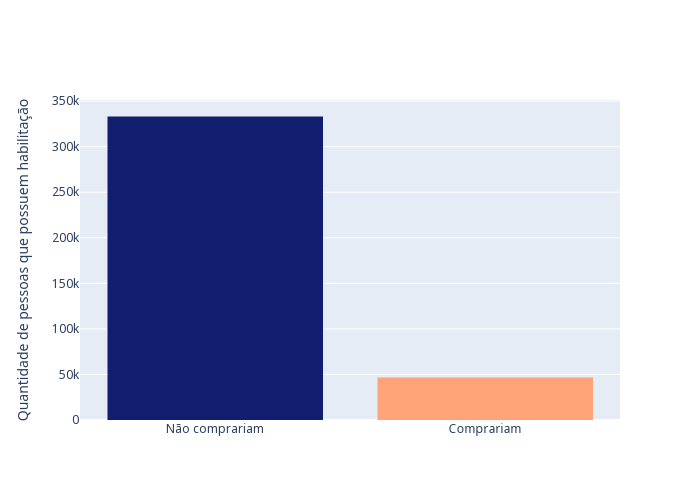

In [27]:
fig = go.Figure([go.Bar(name = 'Não comprariam',x=aux[aux['response']==0]['response'], y=aux[aux['response']==0]['driving_license'], marker_color='#111D6F'),
                 go.Bar(name = 'Comprariam',    x=aux[aux['response']==1]['response'], y=aux[aux['response']==1]['driving_license'], marker_color='#FFA378')])

fig.update_layout(barmode='stack',autosize=False,yaxis_title='Quantidade de pessoas que possuem habilitação',
                  xaxis = dict(tickmode = 'array', tickvals = [0, 1], ticktext = ['Não comprariam', 'Comprariam']),
                  showlegend = False)
fig.show('png')

fig = go.Figure([go.Bar(name = 'Não comprariam',x=aux[aux['response']==0]['response'], y=aux[aux['response']==0]['driving_license'], marker_color='#111D6F'),
                 go.Bar(name = 'Comprariam',    x=aux[aux['response']==1]['response'], y=aux[aux['response']==1]['driving_license'], marker_color='#FFA378')])

fig.update_layout(barmode='stack',autosize=False,yaxis_title='Quantidade de pessoas que possuem habilitação',
                  xaxis = dict(tickmode = 'array', tickvals = [0, 1], ticktext = ['Não comprariam', 'Comprariam']),
                  showlegend = False)
fig.show('png')


### **H4** Homens deveriam se interessar mais pelo seguro do que as mulheres



**Verdadeiro** Homens adquirem tem mais interesse em seguro do que mulheres, porém a diferença não é tão desproporcional, cerca de 3% a mais.

In [28]:
aux = df4[['gender', 'response']].groupby(['gender', 'response']).size().reset_index(name='quantidade_genero')


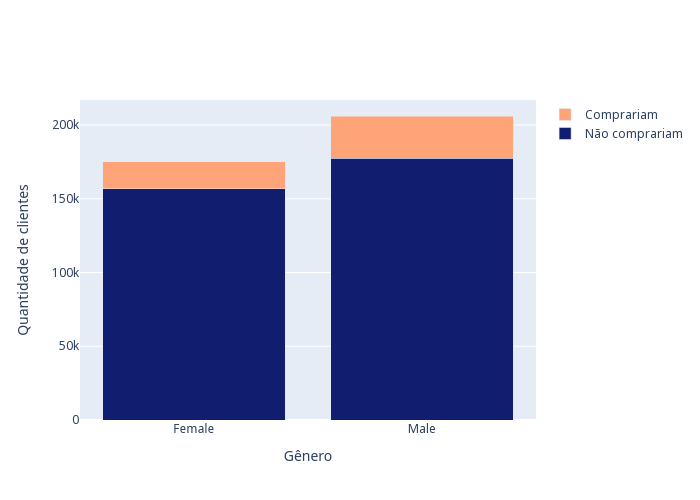

In [29]:
fig = go.Figure([go.Bar(name = 'Não comprariam',x=aux[aux['response']==0]['gender'], y=aux[aux['response']==0]['quantidade_genero'], marker_color='#111D6F'),
                 go.Bar(name = 'Comprariam',    x=aux[aux['response']==1]['gender'], y=aux[aux['response']==1]['quantidade_genero'], marker_color='#FFA378')])

fig.update_layout(barmode='stack', xaxis_title='Gênero', yaxis_title='Quantidade de clientes',autosize=False)
fig.show('png')


### **H5** Pessoas com carros mais antigos dispensam mais o seguro

**Verdadeiro** A maioria dos interessados pelo seguro possuem carros entre um e dois anos. Além disso podemos ver que poucas clientes possuem carros mais velho que 2 anos.

In [30]:
aux = df4[['vehicle_age', 'response']].sort_values(by='vehicle_age').value_counts(normalize=True).reset_index()
aux

vehicle_age  response  proportion
0  between_1_2_year         0    0.434285
1      below_1_year         0    0.413488
2  between_1_2_year         1    0.091328
3       over_2_year         0    0.029663
4      below_1_year         1    0.018897
5       over_2_year         1    0.012338

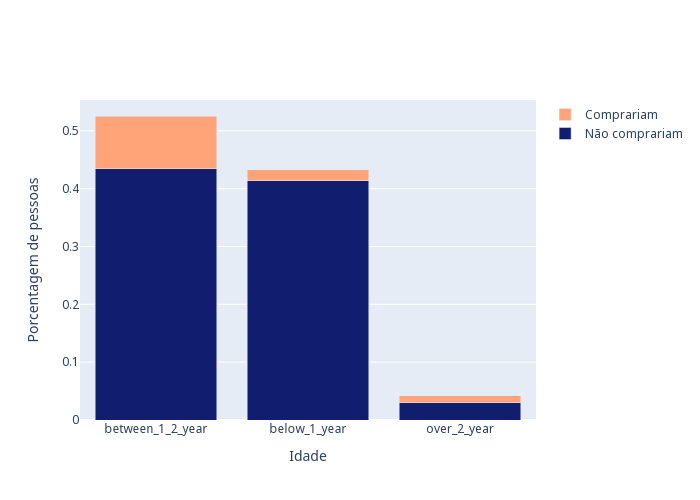

In [31]:
fig = go.Figure([go.Bar(name = 'Não comprariam',x=aux[aux['response']==0]['vehicle_age'], y=aux[aux['response']==0]['proportion'], marker_color='#111D6F'),
                 go.Bar(name = 'Comprariam',    x=aux[aux['response']==1]['vehicle_age'], y=aux[aux['response']==1]['proportion'], marker_color='#FFA378')])

fig.update_layout(barmode='stack',autosize=False, xaxis_title='Idade', yaxis_title='Porcentagem de pessoas')
fig.show('png')


### **H6** Pessoas com carros que ja tiveram o carro danificado tem mais interesse no seguro.

**Verdadeiro** O numero de pessoas que já tiveram o carro danificado alguma vez e são interessadas no seguro é maior.

In [32]:
aux = df4[['vehicle_damage', 'response']].sort_values(by='vehicle_damage').value_counts(normalize=True).reset_index()
aux

vehicle_damage  response  proportion
0               0         0    0.492547
1               1         0    0.384890
2               1         1    0.119987
3               0         1    0.002577

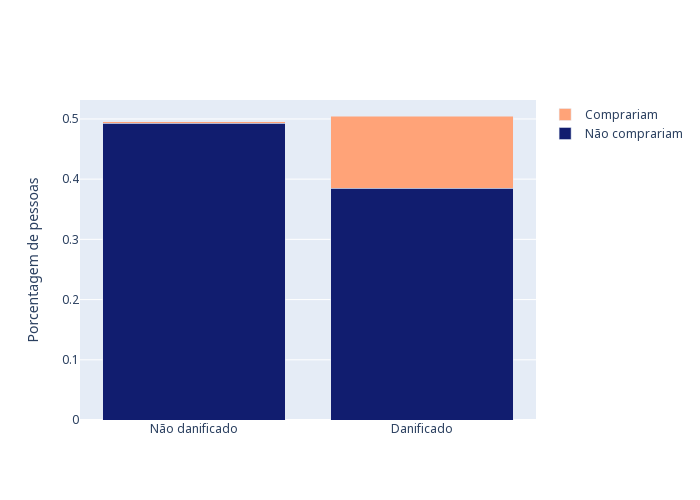

In [33]:
fig = go.Figure([go.Bar(name = 'Não comprariam',x=aux[aux['response']==0]['vehicle_damage'], y=aux[aux['response']==0]['proportion'], marker_color='#111D6F'),
                 go.Bar(name = 'Comprariam',    x=aux[aux['response']==1]['vehicle_damage'], y=aux[aux['response']==1]['proportion'], marker_color='#FFA378')])

fig.update_layout(barmode='stack',autosize=False, 
                  yaxis_title='Porcentagem de pessoas',
                  xaxis = dict(tickmode = 'array', 
                               tickvals = [0, 1], 
                               ticktext = ['Não danificado', 'Danificado']))
fig.show('png')


### **H7** Pessoas que recém adquiriram o plano de saúde podem não se interessar de imediato em um seguro de carro

**Verdadeiro** A hipótese é válida, o maior número de pessoas interessadas no seguro tem entre 4 e 8 meses como cliente da seguradora.

In [34]:
aux = df4[['quadrimestre', 'response']].sort_values(by='quadrimestre').value_counts().reset_index()
aux

quadrimestre  response   count
0             2         0  138411
1             3         0  103659
2             1         0   92329
3             2         1   19320
4             3         1   14415
5             1         1   12975

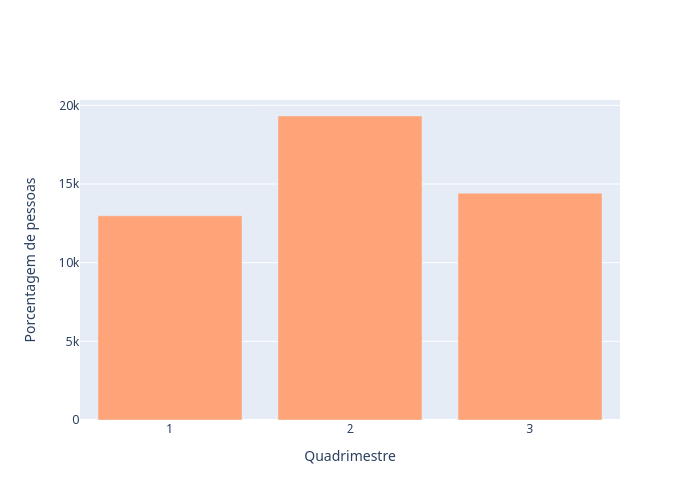

In [35]:
fig = go.Figure([go.Bar(name = 'Comprariam',    x=aux[aux['response']==1]['quadrimestre'], y=aux[aux['response']==1]['count'], marker_color='#FFA378')])

fig.update_layout(barmode='stack',autosize=False, 
                  xaxis_title='Quadrimestre', 
                  yaxis_title='Porcentagem de pessoas',
                  xaxis = dict(tickmode = 'array', 
                               tickvals = [1, 2, 3], 
                               ticktext = ['1', '2', '3']))
fig.show('png')


### **H8** Pessoas no fim do seguro de saúde, quando oferecido renovação, tendem a adquirir o junto o seguro de carro. *(em partes)*

**Falso** Como vemos no item **H7** pessoas no terceiro quadrimestre tem menos interesse do que pessoas no segundo. 

Temos que considerar ainda que a perspectiva do que é um novo e um antigo cliente pode ser diferente de empresa para empresa, mas levando em conta a convenção adotada aqui a hipótese atual é falsa.

### **H9** Pessoas que são contatadas por telefone tendem adquirir o seguro mais que outros meios. *(em partes)*

**Inconclusivo** Aqui não podemos afirmar que o telefone é o meio de comunicação que vende mais pois não é informado o tipo de comunicação de cada código, porém podemos notar que existem os que mais se destacam que são os meios 26 e 124.

In [36]:
#fazer o gráfico como porcentagem estackada
aux = df4[['policy_sales_channel', 'response']].groupby(['policy_sales_channel','response']).size().reset_index(name='qnt_comunic')

In [37]:
aux = df4[['policy_sales_channel', 'response']].groupby(['policy_sales_channel']).count().reset_index()
aux['policy_sales_channel'] = aux.apply(lambda x: x['policy_sales_channel'] if x['response']>3500 else 'outros', axis=1)
aux

ll = aux['policy_sales_channel'].unique().tolist()

aux2 = df4[['policy_sales_channel', 'response']].groupby(['policy_sales_channel','response']).size().reset_index(name='qnt_comunic')
aux2['policy_sales_channel'] = aux2['policy_sales_channel'].apply(lambda x: x if x in ll else 'outros')

aux3 = aux2.groupby(['policy_sales_channel','response']).sum().reset_index()
aux3

aux4 = aux3.loc[:,['policy_sales_channel', 'qnt_comunic']].groupby(['policy_sales_channel']).sum().sort_values(by='qnt_comunic', ascending=False).reset_index()
aux4

sorter = aux4['policy_sales_channel'].to_list()
aux3.sort_values(by="policy_sales_channel", key=lambda column: column.map(lambda e: sorter.index(e)), inplace=True)

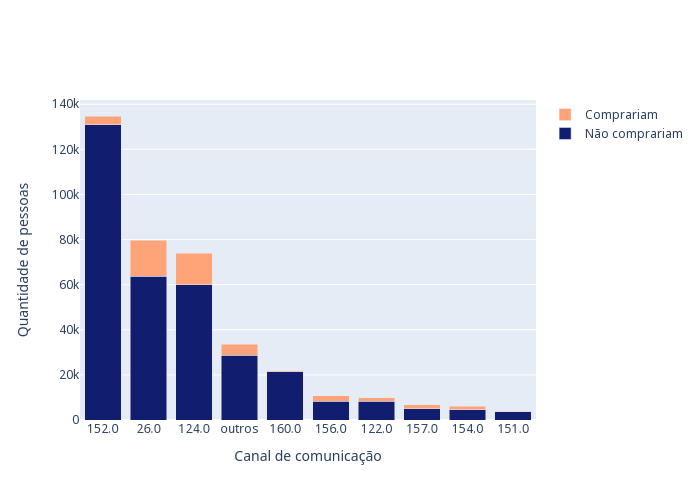

In [38]:
fig = go.Figure([go.Bar(name = 'Não comprariam', y=aux3[aux3['response']==0]['qnt_comunic'], marker_color='#111D6F'),
                 go.Bar(name = 'Comprariam'    , y=aux3[aux3['response']==1]['qnt_comunic'], marker_color='#FFA378')])

fig.update_layout(barmode='stack',autosize=False, 
                  xaxis = dict(tickmode = 'array', 
                               tickvals = [*range(10)], 
                               ticktext = aux3['policy_sales_channel'].astype('str').unique().tolist()),
                  xaxis_title='Canal de comunicação', yaxis_title='Quantidade de pessoas')
fig.show('png')

### Outras análises

#### Relação entre a região do cliente e o interesse no seguro

**Inconclusivo**

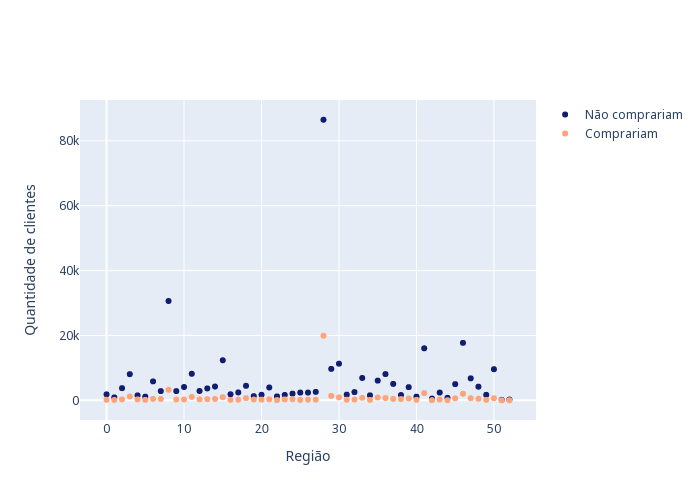

In [39]:
aux = df4[['id','region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()

#sns.scatterplot(x='region_code', y='id', hue='response', data=aux)

fig = go.Figure(data=[go.Scatter(name='Não comprariam',x=aux[aux['response']==0]['region_code'], y=aux[aux['response']==0]['id'],  marker_color='#111D6F', mode='markers'),
                      go.Scatter(name='Comprariam'    ,x=aux[aux['response']==1]['region_code'], y=aux[aux['response']==1]['id'],  marker_color='#FFA378', mode='markers',)])

fig.update_layout(autosize=False,xaxis_title='Região', yaxis_title='Quantidade de clientes')
fig.show('png')

#### Boxplot do tempo como cliente (em dias) e o interesse no seguro.
**Inconclusivo**

In [40]:
fig = go.Figure()
fig.add_trace(go.Box(name='Não comprariam', y=df4[df4['response']==0]['vintage'], marker_color ='#111D6F'))
fig.add_trace(go.Box(name='Comprariam', y=df4[df4['response']==1]['vintage'], marker_color ='#FFA378'))
fig.update_layout(autosize=False, yaxis_title='tempo na base (dias)')

##### Comparação das distribuições do tempo do cliente na base (em dias)

É possível notar, novamente, que os dados se encontram balanceados e que o volume de clientes interessados é menor.

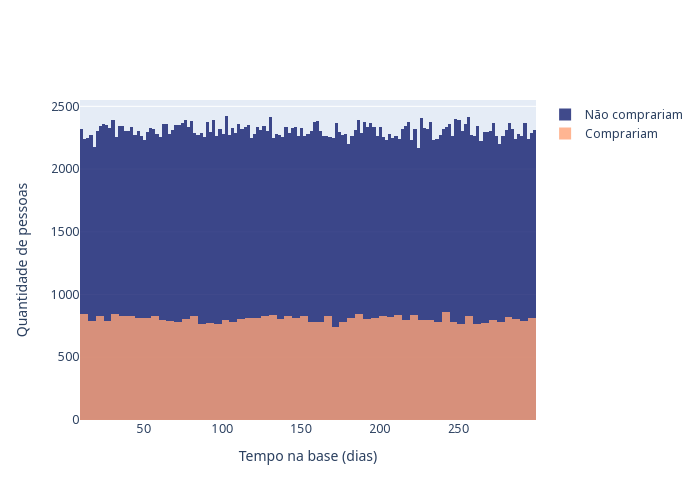

In [41]:
fig = go.Figure()
fig.add_trace(go.Histogram(name='Não comprariam',x=df4.loc[df4['response']==0, 'vintage'], marker_color='#111D6F'))
fig.add_trace(go.Histogram(name='Comprariam', x=df4.loc[df4['response']==1, 'vintage'], marker_color='#FFA378'))

# Overlay both histograms
fig.update_layout(barmode='overlay', autosize=False, xaxis_title='Tempo na base (dias)', yaxis_title='Quantidade de pessoas')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.80)
fig.show('png')


Podemos notar que temos um problema de desbalanceamento dos dados, visto que temos muito mais pessoas desinteressadas em adquirir o seguro. Por conta disso é importante, posteriormente, levar isso em conta ao treinar o modelo.

# 5.0 PREPARAÇÃO DOS DADOS

## 5.1 Separação das bases e balanceamento do dataset

Separação em treino e teste (80% treino). Para balancear os dados foi utilizada a função fit_resample na base de treino.

In [42]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy() 

x_train, x_validation, y_train, y_validation = train_test_split( X, y, test_size=0.20 )

RUS = RandomUnderSampler(sampling_strategy=0.5, random_state=43)

x_train, y_train = RUS.fit_resample(X,y)

df5 = pd.concat( [x_train, y_train], axis=1)


## 5.2 Transformações, Normalizações, Reescalas e Encoding

Ajustando os dados com as técnicas Standard Scaler, Min Max Scaler, One Hot Encoder, Target Encoder e Frequency Encoder

In [43]:
# annual_premium e total expense - Standard Scaler
ssp = pp.StandardScaler()
sse = pp.StandardScaler()

df5['annual_premium'] = ssp.fit_transform(df5[['annual_premium']].values)

df5['total_expense'] = sse.fit_transform(df5[['total_expense']].values)

In [44]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age e vintage - Min Max Scaler

df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump( mms_age, open( os.path.join(MODE_DIR,'features/age_scaler.pkl'), 'wb' ) )

df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump( mms_vintage, open( os.path.join(MODE_DIR,'features/vintage_scaler.pkl'), 'wb' ) )

In [45]:
# gender -  Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
pickle.dump( target_encode_gender, open( os.path.join(MODE_DIR,'features/target_encode_gender_scaler.pkl'), 'wb' ) )

# region_code - Target Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
pickle.dump( target_encode_region_code, open( os.path.join(MODE_DIR,'features/target_encode_region_code_scaler.pkl'), 'wb' ) )

# vehicle_age - One Hot Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel, open( os.path.join(MODE_DIR,'features/fe_policy_sales_channel_scaler.pkl'), 'wb' ) )

## 5.3 Preparação dos dados de validação

Os dados de validação são transformados de acordo com as transformações dos dados de treino

In [46]:
# gender
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map( target_encode_gender )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_validation.loc[:, 'annual_premium'] = ssp.transform( x_validation[['annual_premium']].values )

# tota_expense
x_validation.loc[:, 'total_expense'] = sse.transform( x_validation[['total_expense']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

# 6.0 SELEÇÃO DE FEATURES

## 6.1 Seleção das features mais importantes para o modelo

Foi utilizado o método Extra Trees Classifier para selecionar as principais features

In [47]:
forest = ExtraTreesClassifier(n_estimators = 250, random_state=0, n_jobs=-1)

x_train_n = df5.drop(['id', 'response'], axis = 1)

y_train_n = y_train.values

forest.fit(x_train_n,y_train_n)


ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                       vintage    0.147971
0                vehicle_damage    0.147044
0                           age    0.140126
0                 total_expense    0.127680
0                annual_premium    0.120374
0            previously_insured    0.111324
0                   region_code    0.087612
0          policy_sales_channel    0.057642
0      vehicle_age_below_1_year    0.027584
0  vehicle_age_between_1_2_year    0.013631
0                        gender    0.006816
0                  quadrimestre    0.006365
0       vehicle_age_over_2_year    0.005130
0               driving_license    0.000701


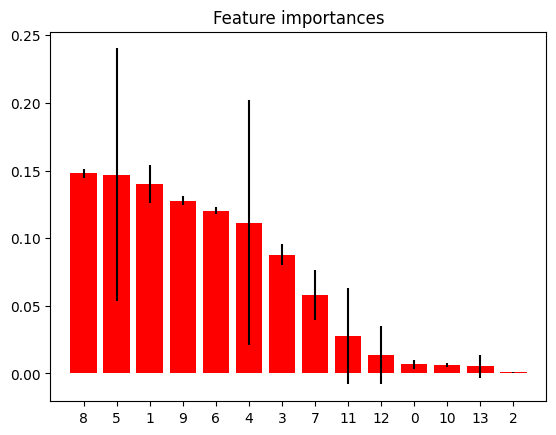

In [48]:

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0 MODELOS DE MACHINE LERNING

Foi aplicado o método de cross validation score para calcular a média  do top k score (em 15% da base) e então determinar o melhor método. Features com menos de 1% de importância foram desconsideradas na modelagem.

In [49]:
cols_selected = ['annual_premium', 'vintage', 'total_expense', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel', 'vehicle_age_between_1_2_year', 'vehicle_age_below_1_year']

x_train = df5[ cols_selected ]

x_val = x_validation[ cols_selected ]
y_val = y_validation

tam = np.floor(y_val.shape[0]*10/100)

## 7.2 KNN

In [50]:
knn = KNeighborsClassifier()


_, _, KNN_cv = cross_validation(x_train, y_train, tam, 5, 'KNN', knn, verbose=True)
KNN_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


Model Name   Precision at k     Recall at k Precision at 25%  \
0        KNN  0.6039+/-0.0045  0.4923+/-0.003  0.6068+/-0.0043   

     Recall at 25% Precision at 50%   Recall at 50% Precision at 75%  \
0  0.4547+/-0.0025  0.5692+/-0.0044  0.853+/-0.0043  0.4342+/-0.0023   

     Recall at 75% Precision at 100% Recall at 100%  
0  0.9761+/-0.0011   0.3337+/-0.0015      1.0+/-0.0

## 7.3 Random Forest

In [51]:
rf = RandomForestClassifier()

_, _, rf_cv = cross_validation(x_train, y_train, tam, 5, 'Random Forest', rf, verbose=True)
rf_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


Model Name   Precision at k      Recall at k Precision at 25%  \
0  Random Forest  0.6323+/-0.0022  0.5168+/-0.0035  0.6348+/-0.0018   

     Recall at 25% Precision at 50%    Recall at 50% Precision at 75%  \
0  0.4769+/-0.0036   0.5831+/-0.002  0.8762+/-0.0056  0.4432+/-0.0025   

     Recall at 75% Precision at 100% Recall at 100%  
0  0.9988+/-0.0003   0.3328+/-0.0019      1.0+/-0.0

## 7.4 Logistic Regression

In [52]:
lr = LogisticRegression()

_, _, lr_cv = cross_validation(x_train, y_train, tam, 5, 'Logistic Regression', lr, verbose=True)
lr_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


Model Name  Precision at k      Recall at k Precision at 25%  \
0  Logistic Regression  0.6381+/-0.004  0.5243+/-0.0033  0.6404+/-0.0037   

     Recall at 25% Precision at 50%    Recall at 50% Precision at 75%  \
0  0.4837+/-0.0032  0.5767+/-0.0043  0.8711+/-0.0046   0.441+/-0.0022   

     Recall at 75% Precision at 100% Recall at 100%  
0  0.9991+/-0.0003    0.331+/-0.0015      1.0+/-0.0

## 7.5 XGBoost

In [53]:
xgb = XGBClassifier()

_, _, xgb_cv = cross_validation(x_train, y_train, tam, 5, 'XGB', xgb, verbose=True)
xgb_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


Model Name   Precision at k      Recall at k Precision at 25%  \
0        XGB  0.6587+/-0.0035  0.5389+/-0.0031  0.6641+/-0.0038   

     Recall at 25% Precision at 50%   Recall at 50% Precision at 75%  \
0  0.4994+/-0.0037   0.595+/-0.0019  0.895+/-0.0023  0.4429+/-0.0023   

     Recall at 75% Precision at 100% Recall at 100%  
0  0.9992+/-0.0001   0.3325+/-0.0017      1.0+/-0.0

## 7.6 Comparação geral

In [54]:
models_result = pd.concat([KNN_cv,rf_cv,lr_cv,xgb_cv], axis=0)
models_result.sort_values('Precision at k', ascending=False)

Model Name   Precision at k      Recall at k Precision at 25%  \
0                  XGB  0.6587+/-0.0035  0.5389+/-0.0031  0.6641+/-0.0038   
0  Logistic Regression   0.6381+/-0.004  0.5243+/-0.0033  0.6404+/-0.0037   
0        Random Forest  0.6323+/-0.0022  0.5168+/-0.0035  0.6348+/-0.0018   
0                  KNN  0.6039+/-0.0045   0.4923+/-0.003  0.6068+/-0.0043   

     Recall at 25% Precision at 50%    Recall at 50% Precision at 75%  \
0  0.4994+/-0.0037   0.595+/-0.0019   0.895+/-0.0023  0.4429+/-0.0023   
0  0.4837+/-0.0032  0.5767+/-0.0043  0.8711+/-0.0046   0.441+/-0.0022   
0  0.4769+/-0.0036   0.5831+/-0.002  0.8762+/-0.0056  0.4432+/-0.0025   
0  0.4547+/-0.0025  0.5692+/-0.0044   0.853+/-0.0043  0.4342+/-0.0023   

     Recall at 75% Precision at 100% Recall at 100%  
0  0.9992+/-0.0001   0.3325+/-0.0017      1.0+/-0.0  
0  0.9991+/-0.0003    0.331+/-0.0015      1.0+/-0.0  
0  0.9988+/-0.0003   0.3328+/-0.0019      1.0+/-0.0  
0  0.9761+/-0.0011   0.3337+/-0.0015      1.0+/-0.0

# 8.0 HYPERPARAMETER FINE TUNING

O melhor resultado considerando também o tempo de processamento foi o XGBoost, portanto seguiremos com ele. Vamos agora otimizar os parâmetros do método utilizando a otimização Gaussiana.

In [55]:
#Espaço de busca
search_space = [Integer(500,2500,name='n_estimators'),
Real(0,0.3,name='eta'),
Integer(2,16,name='max_depth'),
Real(0.4,1,name='subsample'),
Real(0.4,1,name='colsample_bytree'),
Integer(0,10,name='gamma'),
Integer(2,16,name='min_child_weight')]

#Modelo
model = XGBClassifier()

Agora definimos a função objetivo, onde vamos maximizar o top k score e aplicamos o método.

In [56]:
#Função objetivo (Maximizar a precisão (top k))
@use_named_args(search_space)
def evaluate_model(**params):
    model.set_params(**params)
    tkp, tkr, _ = cross_validation(x_train, y_train, tam, 5, 'XGB', xgb, verbose=True)
    topk_mean = np.mean(tkp)
    
    return 1-topk_mean

In [57]:
# Cálculo dos parâmetros ótimos
result = gp_minimize(evaluate_model, search_space, n_calls=25, n_jobs=-1, verbose=True)

Iteration No: 1 started. Evaluating function at random point.

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 14.1360
Function value obtained: 0.3402
Current minimum: 0.3402
Iteration No: 2 started. Evaluating function at random point.

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 13.2796
Function value obtained: 0.3384
Current minimum: 0.3384
Iteration No: 3 started. Evaluating function at random point.

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 13.4248
Function value obtained: 0.3382
Current minimum: 0.3382
Iteration No: 4 started. Evaluating function at random point.

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
Iteration No: 4 

In [58]:
#Melhor acurácia obtida e os parâmetros que resultam nela

print('Best Accuracy: %.3f' % (1.0 - result.fun))
print(result.x[0])
print(result.x[1])
print(result.x[2])
print(result.x[3])
print(result.x[4])
print(result.x[5])
print(result.x[6])


Best Accuracy: 0.665
1817
0.07196008690904827
3
0.6306931409217986
0.9989795523542955
0
10


In [59]:
#Melhores parâmetros:

#n_estimators = 500
#eta = 0.3
#max_depth = 8
#subsample = 1.0
#colsample_bytree = 0.7167210667066474
#gamma = 10
#min_child_weight = 16


## 8.1 Modelo final

Treinando o modelo com os parâmetros ótimos

In [60]:
# model definition
xgb_model = XGBClassifier(n_estimators=result.x[0], 
                          eta=result.x[1], 
                          max_depth=result.x[2], 
                          subsample = result.x[3], 
                          colsample_bytree=result.x[4],
                          gamma=result.x[5],
                          min_child_weight=result.x[6]) 

# model training
xgb_model.fit( x_train, y_train )
pickle.dump(xgb_model, open(os.path.join(MODE_DIR,'final_model.pkl'), 'wb'))
# model prediction
yhat_xgb = xgb_model.predict_proba( x_val )


# 9.0 TRADUÇÃO E INTERPRETAÇÃO DO DOS RESULTADOS

In [61]:
#xgb  = pickle.load(open(os.path.join(MODE_DIR,'final_model.pkl'),'rb'))

Tendo treinado o modelo agora precisamos entender em termos de negócio como foi sua performance. Para isso temos duas curvas, a de ganho acumulado e a de lift. 

A curva de ganho acumulado no diz a porcentagem de pessoas interessadas qua conseguimos atingir em função da porcentagem da base. No nosso caso, no gráfico abaixo, a curva de ganho acumulado (em azul) nos diz que tomando os 20% primeiros da nossa base atingimos em torno de 60% dos interessados, com 40% da base esse valor vai para algo em torno de 95%. A curva em laranja representa o caso em que não ordenamos a base, ou seja, escolhendo os cliente de forma aleatória.

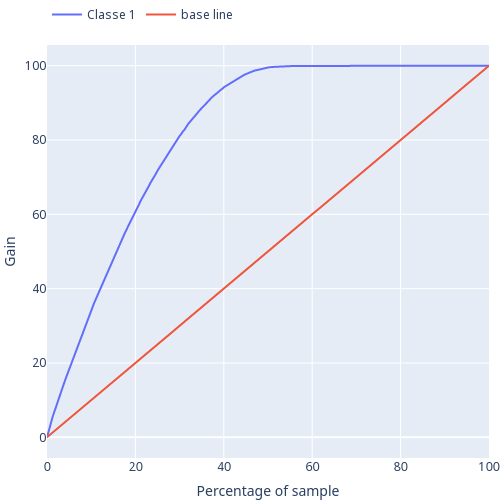

In [62]:
gain_curve(x_val,y_val,xgb)

A curva de lift nos diz quantas vezes a base ordenada utilizando nosso modelo é melhor que o caso da base ordenada aleatoriamente. Observando o gráfico abaixo vemos que considerando 20% da nossa base ordenada é em torno de 3 vezes melhor que no caso aleatório, com 40% temos algo em torno de 2,5 vezes melhor.

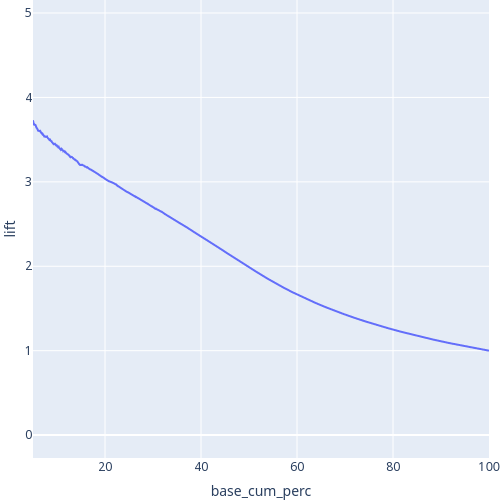

In [63]:
lift_curve(x_val,y_val,xgb)

# 10.0 Consulta do modelo via API

In [64]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   driving_license       381109 non-null  int64  
 4   region_code           381109 non-null  float64
 5   previously_insured    381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  int64  
 8   annual_premium        381109 non-null  float64
 9   policy_sales_channel  381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 34.9+ MB


In [65]:
num_attributes.describe()

age  annual_premium        vintage
count  381109.000000   381109.000000  381109.000000
mean       38.822584    30564.389581     154.347397
std        15.511611    17213.155057      83.671304
min        20.000000     2630.000000      10.000000
25%        25.000000    24405.000000      82.000000
50%        36.000000    31669.000000     154.000000
75%        49.000000    39400.000000     227.000000
max        85.000000   540165.000000     299.000000